<a href="https://colab.research.google.com/github/akinivors/CENG543_Midterm_290201005/blob/main/Question3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- STEP 1: SETUP & DATA LOADING (Multi30k) ---
# Consistency Check: We use the exact same setup as Q2 for fair comparison.

!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install datasets

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import math
import time
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# 1. Set Seed
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Load Tokenizers
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# 3. Load Dataset
print("Downloading Multi30k...")
dataset = load_dataset("bentrevett/multi30k")

def build_vocab(data_split, tokenizer, min_freq=2):
    counter = Counter()
    for item in data_split:
        counter.update(tokenizer(item))
    vocab = {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3}
    idx = 4
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

src_vocab = build_vocab(dataset['train']['de'], tokenize_de)
trg_vocab = build_vocab(dataset['train']['en'], tokenize_en)

# 4. DataLoaders
def collate_batch(batch):
    src_list, trg_list = [], []
    for item in batch:
        src_tensor = torch.tensor([src_vocab.get(t, src_vocab['<unk>']) for t in tokenize_de(item['de'])], dtype=torch.long)
        src_tensor = torch.cat([torch.tensor([src_vocab['<sos>']]), src_tensor, torch.tensor([src_vocab['<eos>']])])

        trg_tensor = torch.tensor([trg_vocab.get(t, trg_vocab['<unk>']) for t in tokenize_en(item['en'])], dtype=torch.long)
        trg_tensor = torch.cat([torch.tensor([trg_vocab['<sos>']]), trg_tensor, torch.tensor([trg_vocab['<eos>']])])

        src_list.append(src_tensor)
        trg_list.append(trg_tensor)

    # BATCH_FIRST=True is critical for Transformers!
    src_padded = pad_sequence(src_list, padding_value=src_vocab['<pad>'], batch_first=True)
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab['<pad>'], batch_first=True)
    return src_padded, trg_padded

BATCH_SIZE = 128
train_iter = DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_iter = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_iter = DataLoader(dataset['test'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print("Q3 Data Setup Complete.")

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.8.0/de_core_news_sm-3.8.0-py3-none-any.whl (14.6 MB)
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Q3 Data Setup Complete.


In [2]:
# --- STEP 2: TRANSFORMER MODEL DEFINITION ---

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super().__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Embeddings
        self.src_tok_emb = nn.Embedding(input_dim, d_model)
        self.trg_tok_emb = nn.Embedding(output_dim, d_model)

        # Core Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Output Head
        self.generator = nn.Linear(d_model, output_dim)

    def forward(self, src, trg):
        # Create Masks for the Transformer
        # 1. Padding Masks (ignore <pad> tokens)
        src_padding_mask = (src == src_vocab['<pad>'])
        trg_padding_mask = (trg == trg_vocab['<pad>'])

        # 2. Causal Mask (prevent decoder from looking at future tokens)
        trg_len = trg.size(1)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_len).to(device)

        # Apply Embeddings + Positional Encoding
        src_emb = self.pos_encoder(self.src_tok_emb(src) * math.sqrt(self.d_model))
        trg_emb = self.pos_encoder(self.trg_tok_emb(trg) * math.sqrt(self.d_model))

        # Pass through Transformer
        outs = self.transformer(
            src=src_emb,
            tgt=trg_emb,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=trg_padding_mask,
            memory_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask
        )

        return self.generator(outs)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)

print("Transformer Architecture Ready.")

Transformer Architecture Ready.


In [3]:
# --- STEP 3: ABLATION STUDY & TRAINING LOOP ---
import time
import math
from tqdm import tqdm

# 1. Training Support Functions
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

def train_epoch(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        # Transformer expects:
        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len] -> Inputs to decoder need to shift by 1 (exclude last token)
        trg_input = trg[:, :-1]

        output = model(src, trg_input)
        # output: [batch_size, trg_len-1, output_dim]

        # Reshape for loss calculation
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)

        # Targets need to exclude first token (<sos>)
        trg_target = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg_target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)
            trg_input = trg[:, :-1]
            output = model(src, trg_input)

            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            trg_target = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg_target)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# --- ABLATION CONFIGURATIONS ---
# Task (e): Vary layers and attention heads
experiments = {
    "Baseline (3L, 8H)": {'layers': 3, 'heads': 8},
    "Deep (6L, 8H)":     {'layers': 6, 'heads': 8},
    "Wide (3L, 16H)":    {'layers': 3, 'heads': 16}
}

INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
HID_DIM = 256
FF_DIM = 512
DROPOUT = 0.1
N_EPOCHS = 10
CLIP = 1
TRG_PAD_IDX = trg_vocab['<pad>']

results = {}

print(f"Starting Ablation Study on {list(experiments.keys())}...")

for name, config in experiments.items():
    print(f"\n{'='*20}\nTraining {name}\n{'='*20}")

    # 1. Initialize Specific Architecture
    model = TransformerModel(
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        d_model=HID_DIM,
        nhead=config['heads'],
        num_encoder_layers=config['layers'],
        num_decoder_layers=config['layers'],
        dim_feedforward=FF_DIM,
        dropout=DROPOUT
    ).to(device)

    model.apply(initialize_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

    best_valid_loss = float('inf')
    total_train_time = 0

    # 2. Training Loop
    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss = train_epoch(model, train_iter, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, valid_iter, criterion)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        total_train_time += (end_time - start_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'transformer_{name.replace(" ", "_").replace("(", "").replace(")", "").replace(",", "")}.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    # Store results for comparison
    results[name] = {
        'Best Val PPL': math.exp(best_valid_loss),
        'Total Time': total_train_time
    }

print("\n--- Ablation Study Complete ---")
for name, stats in results.items():
    print(f"{name}: PPL={stats['Best Val PPL']:.2f}, Time={stats['Total Time']:.1f}s")

Starting Ablation Study on ['Baseline (3L, 8H)', 'Deep (6L, 8H)', 'Wide (3L, 16H)']...

Training Baseline (3L, 8H)


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch: 01 | Time: 0m 11s
	Train Loss: 4.370 | Train PPL:  79.077
	 Val. Loss: 3.260 |  Val. PPL:  26.051
Epoch: 02 | Time: 0m 9s
	Train Loss: 2.904 | Train PPL:  18.251
	 Val. Loss: 2.355 |  Val. PPL:  10.538
Epoch: 03 | Time: 0m 9s
	Train Loss: 2.242 | Train PPL:   9.414
	 Val. Loss: 1.969 |  Val. PPL:   7.165
Epoch: 04 | Time: 0m 9s
	Train Loss: 1.856 | Train PPL:   6.396
	 Val. Loss: 1.767 |  Val. PPL:   5.855
Epoch: 05 | Time: 0m 9s
	Train Loss: 1.590 | Train PPL:   4.903
	 Val. Loss: 1.639 |  Val. PPL:   5.148
Epoch: 06 | Time: 0m 9s
	Train Loss: 1.397 | Train PPL:   4.043
	 Val. Loss: 1.597 |  Val. PPL:   4.938
Epoch: 07 | Time: 0m 9s
	Train Loss: 1.246 | Train PPL:   3.476
	 Val. Loss: 1.556 |  Val. PPL:   4.740
Epoch: 08 | Time: 0m 9s
	Train Loss: 1.120 | Train PPL:   3.065
	 Val. Loss: 1.549 |  Val. PPL:   4.705
Epoch: 09 | Time: 0m 9s
	Train Loss: 1.017 | Train PPL:   2.764
	 Val. Loss: 1.566 |  Val. PPL:   4.786
Epoch: 10 | Time: 0m 9s
	Train Loss: 0.929 | Train PPL:   2.531

Starting Long-Term Training (100 epochs) for ALL models...
Using Lower Learning Rate: 0.0001 (Critical for stability)

Resuming Baseline (3L, 8H)
✅ Loaded weights from transformer_Baseline_3L_8H.pt
Epoch: 010 | Time: 0m 9s
	Train PPL:   1.946 | Val PPL:   5.059
Epoch: 020 | Time: 0m 9s
	Train PPL:   1.633 | Val PPL:   5.823
Epoch: 030 | Time: 0m 9s
	Train PPL:   1.446 | Val PPL:   6.748
Epoch: 040 | Time: 0m 9s
	Train PPL:   1.326 | Val PPL:   7.982
Epoch: 050 | Time: 0m 9s
	Train PPL:   1.245 | Val PPL:   9.167
Epoch: 060 | Time: 0m 9s
	Train PPL:   1.189 | Val PPL:  10.568
Epoch: 070 | Time: 0m 9s
	Train PPL:   1.152 | Val PPL:  11.756
Epoch: 080 | Time: 0m 9s
	Train PPL:   1.124 | Val PPL:  13.025
Epoch: 090 | Time: 0m 9s
	Train PPL:   1.104 | Val PPL:  14.341
Epoch: 100 | Time: 0m 9s
	Train PPL:   1.089 | Val PPL:  15.639
Finished Baseline (3L, 8H). Best PPL: 4.603


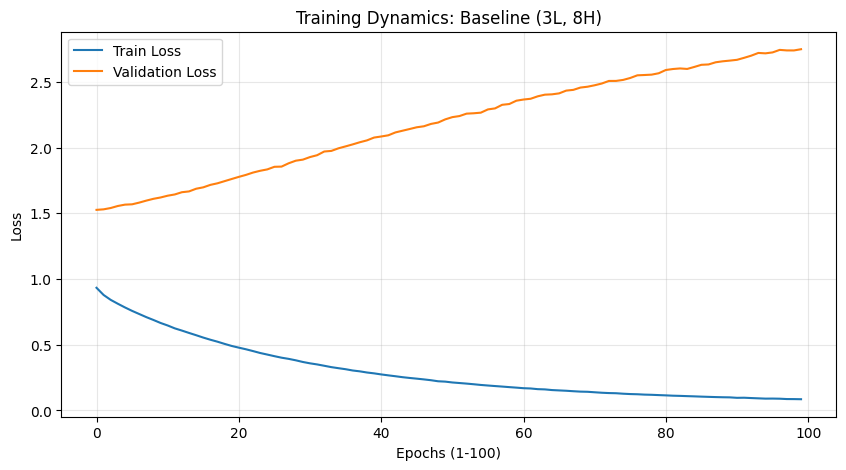


Resuming Deep (6L, 8H)
✅ Loaded weights from transformer_Deep_6L_8H.pt
Epoch: 010 | Time: 0m 14s
	Train PPL:  23.761 | Val PPL:  21.530
Epoch: 020 | Time: 0m 14s
	Train PPL:   8.951 | Val PPL:   9.525
Epoch: 030 | Time: 0m 14s
	Train PPL:   4.508 | Val PPL:   5.964
Epoch: 040 | Time: 0m 14s
	Train PPL:   3.069 | Val PPL:   5.413
Epoch: 050 | Time: 0m 14s
	Train PPL:   2.378 | Val PPL:   5.576
Epoch: 060 | Time: 0m 14s
	Train PPL:   1.964 | Val PPL:   5.955
Epoch: 070 | Time: 0m 14s
	Train PPL:   1.690 | Val PPL:   6.806
Epoch: 080 | Time: 0m 14s
	Train PPL:   1.502 | Val PPL:   7.657
Epoch: 090 | Time: 0m 14s
	Train PPL:   1.374 | Val PPL:   8.849
Epoch: 100 | Time: 0m 14s
	Train PPL:   1.284 | Val PPL:  10.135
Finished Deep (6L, 8H). Best PPL: 5.370


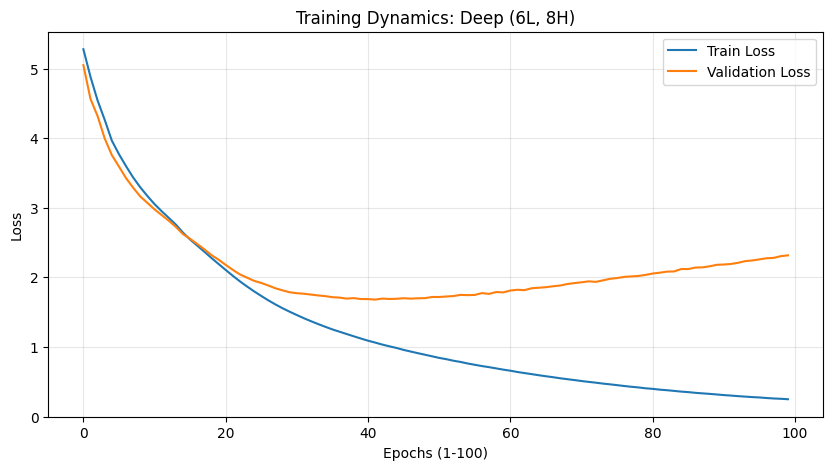


Resuming Wide (3L, 16H)
✅ Loaded weights from transformer_Wide_3L_16H.pt
Epoch: 010 | Time: 0m 9s
	Train PPL:   1.908 | Val PPL:   5.229
Epoch: 020 | Time: 0m 9s
	Train PPL:   1.598 | Val PPL:   6.014
Epoch: 030 | Time: 0m 9s
	Train PPL:   1.415 | Val PPL:   7.042
Epoch: 040 | Time: 0m 9s
	Train PPL:   1.296 | Val PPL:   8.313
Epoch: 050 | Time: 0m 9s
	Train PPL:   1.221 | Val PPL:   9.638
Epoch: 060 | Time: 0m 9s
	Train PPL:   1.170 | Val PPL:  11.078
Epoch: 070 | Time: 0m 9s
	Train PPL:   1.135 | Val PPL:  12.301
Epoch: 080 | Time: 0m 9s
	Train PPL:   1.111 | Val PPL:  13.961
Epoch: 090 | Time: 0m 9s
	Train PPL:   1.092 | Val PPL:  15.547
Epoch: 100 | Time: 0m 9s
	Train PPL:   1.079 | Val PPL:  16.920
Finished Wide (3L, 16H). Best PPL: 4.721


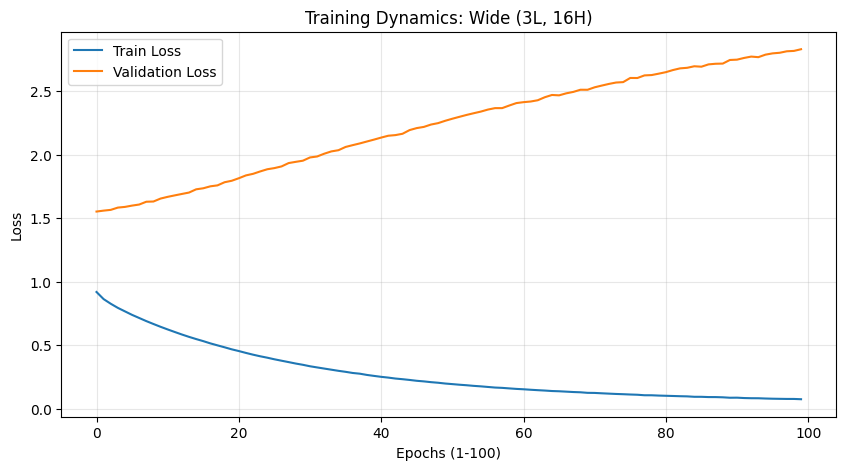


All Long-Term Experiments Complete!


In [4]:
# --- STEP 6: LONG-TERM TRAINING (All 3 Models, 100 Epochs) ---
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import time

# Define the same configurations as the Ablation Study
experiments = {
    "Baseline (3L, 8H)": {'layers': 3, 'heads': 8},
    "Deep (6L, 8H)":     {'layers': 6, 'heads': 8},
    "Wide (3L, 16H)":    {'layers': 3, 'heads': 16}
}

# Training Config
N_EXTRA_EPOCHS = 100
CLIP = 1
NEW_LR = 0.0001  # Lower LR to help stabilize the "Deep" model

print(f"Starting Long-Term Training ({N_EXTRA_EPOCHS} epochs) for ALL models...")
print(f"Using Lower Learning Rate: {NEW_LR} (Critical for stability)")

for name, config in experiments.items():
    clean_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace(",", "")
    filename = f'transformer_{clean_name}.pt'
    save_name = f'transformer_{clean_name}_LONG.pt'

    print(f"\n{'='*20}\nResuming {name}\n{'='*20}")

    # 1. Re-Initialize Specific Architecture
    model = TransformerModel(
        input_dim=len(src_vocab),
        output_dim=len(trg_vocab),
        d_model=256,
        nhead=config['heads'],
        num_encoder_layers=config['layers'],
        num_decoder_layers=config['layers'],
        dim_feedforward=512,
        dropout=0.1
    ).to(device)

    # 2. Load Previous Best Weights
    try:
        model.load_state_dict(torch.load(filename, map_location=device))
        print(f"✅ Loaded weights from {filename}")
    except FileNotFoundError:
        print(f"❌ Could not find {filename}. Skipping...")
        continue

    # 3. Setup Optimizer with Lower LR
    optimizer = torch.optim.Adam(model.parameters(), lr=NEW_LR)
    criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab['<pad>'])

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')

    # 4. Training Loop
    for epoch in range(N_EXTRA_EPOCHS):
        start_time = time.time()

        train_loss = train_epoch(model, train_iter, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, valid_iter, criterion)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_name)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1:03} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain PPL: {math.exp(train_loss):7.3f} | Val PPL: {math.exp(valid_loss):7.3f}')

    print(f"Finished {name}. Best PPL: {math.exp(best_valid_loss):.3f}")

    # 5. Plot Learning Curve for this Model
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs (1-100)')
    plt.ylabel('Loss')
    plt.title(f'Training Dynamics: {name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    # Save the plot with a unique name
    plt.savefig(f'learning_curve_{clean_name}.png')
    plt.show()

print("\nAll Long-Term Experiments Complete!")

In [6]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.5 MB/s eta 0:00:00


Loading original best model: transformer_Baseline_3L_8H.pt...
✅ Weights loaded successfully.
Generating translations for Test Set (this takes ~1 minute)...


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]



=== FINAL TRANSFORMER RESULTS (Baseline 10-Epoch) ===
BLEU: 0.1163
ROUGE-L: 0.3976

✅ Comparison Plot Saved to Q3_Final_Comparison.png


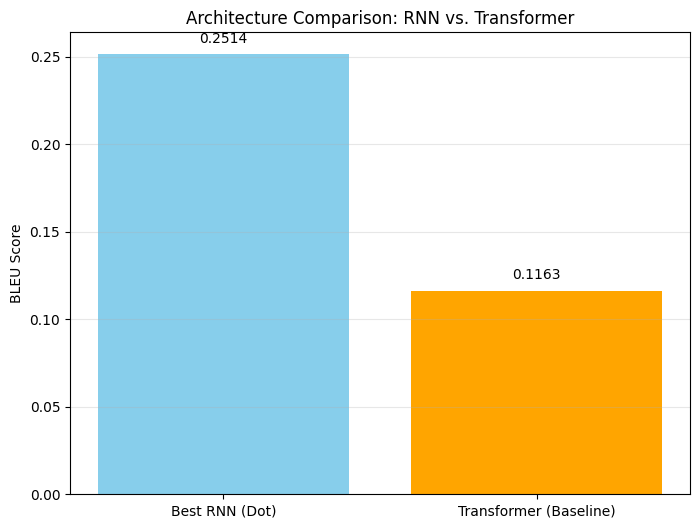

In [9]:
# --- STEP 7: FINAL COMPARATIVE EVALUATION (CORRECTED) ---
# This loads the 10-Epoch Baseline Model (avoiding the overfitted 100-epoch version)

import matplotlib.pyplot as plt
import torch
import math
import numpy as np
from tqdm import tqdm
from torchmetrics.text import BLEUScore, ROUGEScore

# 1. Load the BEST Original Transformer (10 Epochs)
# We use the standard filename, NOT the '_LONG.pt' one
model_name = 'transformer_Baseline_3L_8H.pt'
print(f"Loading original best model: {model_name}...")

# Re-initialize Architecture (Must match the saved model exactly)
model = TransformerModel(
    input_dim=len(src_vocab),
    output_dim=len(trg_vocab),
    d_model=256,
    nhead=8,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=512,
    dropout=0.1
).to(device)

# Load Weights
try:
    model.load_state_dict(torch.load(model_name, map_location=device))
    print("✅ Weights loaded successfully.")
except FileNotFoundError:
    print(f"❌ Error: {model_name} not found. Make sure you ran the Ablation Study (Step 3) first.")

# 2. Translation Function (Greedy Decoding)
def translate_transformer(sentence, model, max_len=50):
    model.eval()

    # Tokenize
    if isinstance(sentence, str):
        tokens = [token.text for token in spacy_de.tokenizer(sentence)]
    else:
        tokens = sentence

    # Numericalize
    tokens = [src_vocab.get(t, src_vocab['<unk>']) for t in tokens]
    tokens = [src_vocab['<sos>']] + tokens + [src_vocab['<eos>']]

    # Convert to Tensor & Add Batch Dimension [1, seq_len]
    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)

    # Create Padding Mask
    src_mask = (src_tensor == src_vocab['<pad>'])

    with torch.no_grad():
        # Encoder Pass
        src_emb = model.pos_encoder(model.src_tok_emb(src_tensor) * math.sqrt(model.d_model))
        memory = model.transformer.encoder(src_emb, src_key_padding_mask=src_mask)

    # Auto-Regressive Decoder Loop
    trg_indexes = [trg_vocab['<sos>']]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # Create Target Mask (Causal)
        trg_mask = model.transformer.generate_square_subsequent_mask(trg_tensor.size(1)).to(device)

        with torch.no_grad():
            trg_emb = model.pos_encoder(model.trg_tok_emb(trg_tensor) * math.sqrt(model.d_model))

            # Decoder Pass
            output = model.transformer.decoder(
                trg_emb,
                memory,
                tgt_mask=trg_mask,
                memory_key_padding_mask=src_mask
            )

            # Get prediction for the last token
            pred_token_logits = model.generator(output[:, -1, :])
            pred_token = pred_token_logits.argmax(1).item()

        trg_indexes.append(pred_token)

        if pred_token == trg_vocab['<eos>']:
            break

    # Convert indices to words
    trg_tokens = [list(trg_vocab.keys())[list(trg_vocab.values()).index(i)] for i in trg_indexes]

    # Return sentence without <sos> and <eos>
    return trg_tokens[1:-1]

# 3. Calculate Metrics on Test Set
bleu = BLEUScore()
rouge = ROUGEScore()
preds, targets = [], []

print("Generating translations for Test Set (this takes ~1 minute)...")
raw_test = dataset['test']

# Iterate through test set
for i in tqdm(range(len(raw_test))):
    src = raw_test[i]['de']
    trg = raw_test[i]['en']

    pred_tokens = translate_transformer(src, model)
    pred_str = " ".join(pred_tokens)

    preds.append(pred_str)
    targets.append(trg)

# Compute Final Scores
b_score = bleu(preds, [[t] for t in targets])
r_score = rouge(preds, targets)

print(f"\n=== FINAL TRANSFORMER RESULTS (Baseline 10-Epoch) ===")
print(f"BLEU: {b_score.item():.4f}")
print(f"ROUGE-L: {r_score['rougeL_fmeasure'].item():.4f}")

# 4. Visual Comparison (Transformer vs RNN)
# We use the best RNN score from Question 2 (approx 0.2514)
rnn_bleu = 0.2514
transformer_bleu = b_score.item()

plt.figure(figsize=(8, 6))
bars = plt.bar(['Best RNN (Dot)', 'Transformer (Baseline)'],
               [rnn_bleu, transformer_bleu],
               color=['skyblue', 'orange'])

plt.ylabel('BLEU Score')
plt.title('Architecture Comparison: RNN vs. Transformer')
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", va='bottom', ha='center')

# Save the plot
plt.savefig('Q3_Final_Comparison.png')
print("\n✅ Comparison Plot Saved to Q3_Final_Comparison.png")
plt.show()